In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
true_class = np.random.choice([0, 1], size=3000)

In [2]:
predictions = np.random.uniform(low=0, high=1, size=3000)

In [3]:
thresholds = np.arange(1, 0, -0.01)

In [4]:
print(true_class[:10], predictions[:10], thresholds[:10])

[1 1 1 1 1 0 1 1 1 0] [ 0.73021212  0.21878345  0.02869216  0.31627144  0.31445762  0.55204834
  0.50179393  0.15007752  0.71324632  0.87190116] [ 1.    0.99  0.98  0.97  0.96  0.95  0.94  0.93  0.92  0.91]


## Lets take a single threshold and calculate True Positive, True Negative, False Positive, False Negative

In [5]:
threshold = 0.99
TP = sum((predictions > threshold) & (true_class==1))
TN = sum((predictions < threshold) & (true_class==0))
FP = sum((predictions > threshold) & (true_class==1))
FN = sum((predictions < threshold) & (true_class==1))
print(TP, TN, FP, FN)

14 1494 14 1478


## Since threshold is pretty low, we can see that  true negative and false negative are both also low. Now let's calculate False Positive Rate and True Positive Rate

In [6]:
FPR = FP/(FP+TN)
TPR = TP/(TP+FN)
print(FPR, TPR)

0.00928381962865 0.00938337801609


## We can see that FPR&TPR are pretty close to 0

In [7]:
FPR = []
TPR = []
for threshold in thresholds:
    TP = sum((predictions > threshold) & (true_class==1))
    TN = sum((predictions < threshold) & (true_class==0))
    FP = sum((predictions > threshold) & (true_class==0))
    FN = sum((predictions < threshold) & (true_class==1))
    FPR.append(FP/(FP+TN))
    TPR.append(TP/(TP+FN))

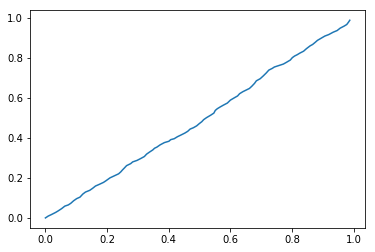

In [8]:
import matplotlib.pyplot as plt

plt.plot(FPR, TPR)
plt.show()

## We can see that the ROC is a straight line, and the area under the curve is about 0.5 (since it's a right triangle with two legs equal to 1)

In [9]:
better_predictions = (predictions + 0.1*true_class)/1.1

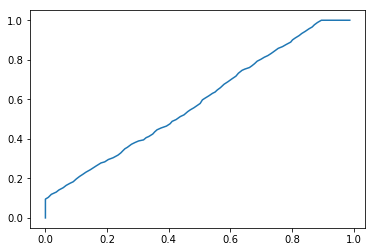

In [10]:
FPR = []
TPR = []
for threshold in thresholds:
    TP = sum((better_predictions > threshold) & (true_class==1))
    TN = sum((better_predictions < threshold) & (true_class==0))
    FP = sum((better_predictions > threshold) & (true_class==0))
    FN = sum((better_predictions < threshold) & (true_class==1))
    FPR.append(FP/(FP+TN))
    TPR.append(TP/(TP+FN))
plt.plot(FPR, TPR)
plt.show()

## We can see that the new ROC is slightly above a straight line, so the area under it would be > 0.5. Let's now see how ROC changes while we get progressively closer to true predictions

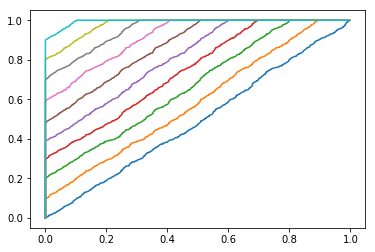

In [11]:
def ROC(trues, preds):
    threshs = np.arange(1.0, 0, -0.001)
    FPR = []
    TPR = []
    for threshold in threshs:
        TP = sum((preds > threshold) & (trues==1))
        TN = sum((preds < threshold) & (trues==0))
        FP = sum((preds > threshold) & (trues==0))
        FN = sum((preds < threshold) & (trues==1))
        FPR.append(FP/(FP+TN))
        TPR.append(TP/(TP+FN))
    return FPR, TPR

weights = np.arange(0.0, 1.0, 0.1)
for weight in weights:
    better_predictions = (predictions + weight*true_class)/(1+weight)
    FPR, TPR = ROC(true_class, better_predictions)
    plt.plot(FPR, TPR)
plt.show()

## We can see that as our predictions are becoming better the ROC gets higher and higher, until it gets close to almost 1 (a square with side = 1). Now let's calculate the *approximate* value of ROC AUC for our last set of predictions

In [12]:
inds = sorted([FPR.index(x) for x in set(FPR)])
FPR_unique = [FPR[i] for i in inds]
TPR_unique = [TPR[i] for i in inds]
FPR_diff = [t - s for s, t in zip(FPR_unique, FPR_unique[1:])]
auc = sum([x*y for (x, y) in zip(FPR_diff, TPR_unique)])
print(auc)

0.989973048122


## Lets now check our calculations with sklearn and see that the results are close

In [224]:
weights = np.arange(0.0, 1.0, 0.1)
for weight in weights:
    better_predictions = (predictions + weight*true_class)/(1+weight)
    FPR, TPR = ROC(true_class, better_predictions)
    inds = sorted([FPR.index(x) for x in set(FPR)])
    FPR_unique = [FPR[i] for i in inds]
    TPR_unique = [TPR[i] for i in inds]
    FPR_diff = [t - s for s, t in zip(FPR_unique, FPR_unique[1:])]
    auc = sum([x*y for (x, y) in zip(FPR_diff, TPR_unique)])
    fpr, tpr, thresholds = metrics.roc_curve(true_class, better_predictions, pos_label=1)
    print(auc, metrics.auc(fpr, tpr))

0.50375102911 0.505241571965
0.598354935017 0.599933496806
0.682541933465 0.684459234787
0.75679968491 0.758877020657
0.820042177962 0.822270657333
0.87436675267 0.87678104979
0.917680069846 0.92094521666
0.95144733356 0.955347283593
0.976659423627 0.979860556671
0.991870251201 0.99517096122


## Lastly, we will check out an easier way to interpret ROC AUC: the probability of correctly rating a pair of one and zero from true_class

In [37]:
pos_ones = np.where(true_class == 1)[0]
pos_zeroes = np.where(true_class == 0)[0]

In [38]:
successes = 0
for i in range(10000):
    if (better_predictions[np.random.choice(pos_ones, 1)[0]] >
        better_predictions[np.random.choice(pos_zeroes, 1)[0]]):
        successes+=1
auc = successes/10000

## Compare it to sklearn:

In [39]:
weights = np.arange(0.0, 1.0, 0.1)
num_experiments = 100000
for weight in weights:
    successes = 0
    better_predictions = (predictions + weight*true_class)/(1+weight)
    for i in range(num_experiments):
        if (better_predictions[np.random.choice(pos_ones, 1)[0]] >
            better_predictions[np.random.choice(pos_zeroes, 1)[0]]):
            successes+=1
    auc = successes/num_experiments
    fpr, tpr, thresholds = metrics.roc_curve(true_class, better_predictions, pos_label=1)
    print(auc, metrics.auc(fpr, tpr))

0.491554 0.492132665107
0.588648 0.587810942178
0.67322 0.672599131709
0.747554 0.747266144459
0.813307 0.812390663557
0.869626 0.869163389536
0.91654 0.916864301918
0.953167 0.953392896509
0.979254 0.979036737045
0.994577 0.994647847761
